# Tutorial - examples of all metrics

This notebook shows the functionality of the different metrics included in the library. 

For this purpose, we use a pre-trained ResNet-18 model and X dataset.

In [1]:
# Mount Google Drive. #remove
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

# Install packages. #remove
!pip install captum opencv-python torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# Imports general.
import sys
import warnings
import gc
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import captum
from torchvision import transforms
from tqdm import tqdm
from captum.attr import *
import random

# Import package.
sys.path.append('/content/drive/MyDrive/Projects/xai_quantification_toolbox')
import quantus

# Notebook settings.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
warnings.filterwarnings("ignore", category=UserWarning)
%load_ext autoreload
%autoreload 2

# Collect garbage.
gc.collect()
torch.cuda.empty_cache()

Mounted at /content/drive
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 1.4 MB 7.2 MB/s 
     |█████████████▌                  | 834.1 MB 1.3 MB/s eta 0:14:32tcmalloc: large alloc 1147494400 bytes == 0x55f106454000 @  0x7f06d426f615 0x55f0cbd1402c 0x55f0cbdf417a 0x55f0cbd16e4d 0x55f0cbe08c0d 0x55f0cbd8b0d8 0x55f0cbd85c35 0x55f0cbd1873a 0x55f0cbd8af40 0x55f0cbd85c35 0x55f0cbd1873a 0x55f0cbd8793b 0x55f0cbe09a56 0x55f0cbd86fb3 0x55f0cbe09a56 0x55f0cbd86fb3 0x55f0cbe09a56 0x55f0cbd86fb3 0x55f0cbd18b99 0x55f0cbd5be79 0x55f0cbd177b2 0x55f0cbd8ae65 0x55f0cbd85c35 0x55f0cbd1873a 0x55f0cbd8793b 0x55f0cbd85c35 0x55f0cbd1873a 0x55f0cbd86b0e 0x55f0cbd1865a 0x55f0cbd86d67 0x55f0cbd85c35
     |█████████████████               | 1055.7 MB 1.2 MB/s eta 0:12:32tcmalloc: large alloc 1434370048 bytes == 0x55f14aaaa000 @  0x7f06d426f615 0x55f0cbd1402c 0x55f0cbdf417a 0x55f0cbd16e4d 0x55f0cbe08c0d 0x55f0cbd8b0d8 0x55f0cbd85c35 0x55f0cbd1873a 0x55

## Preliminaries

### Load datasets

We will then load a batch of input, output pairs that we generate explanations for, then to evaluate.

In [4]:
# Load test data and make loaders.
test_set = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/imagenet_images',
                                            transform=transforms.Compose([transforms.Resize(256),
                                                                          transforms.CenterCrop((224, 224)),
                                                                          transforms.ToTensor(),
                                                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=24)

# Load a batch of inputs and outputs to use for evaluation.
x_batch, y_batch = iter(test_loader).next()
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

### Load a torch model

In this example we load a pre-trained ResNet-18 model but it goes without saying that any model works.

In [5]:
def evaluate_model(model, data, device):
    """Evaluate accuracy of torch model."""
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor().to(device)

    with torch.no_grad():
        for images, labels in data:
            images, labels = images.to(device), labels.to(device)
            logits = torch.cat([logits, model(images)])
            targets = torch.cat([targets, labels])
            
    return np.mean(np.argmax(logits.cpu().numpy(), axis=1) == targets.cpu().numpy())
    
# Load pre-trained ResNet18 model.
model = torchvision.models.resnet18(pretrained=True)
model = model.to(device)

# Evaluate model performance.
#print(f"\nModel test accuracy: {(100 * evaluate_model(model.to(device), test_loader, device)):.2f}%")

### Generate attribution-based explanations

There exist multiple ways to generate explanations for neural network models e.g., using `captum` or `innvestigate` libraries. In this example, we rely on the `quantus.explain` functionality (a simple wrapper around `captum`) however use whatever approach or library you'd like to create your explanations.

**Requirements.**

* **Data type.** Similar to the x-y pairs, the attributions should also be of type `np.ndarray`
* **Shape.** Sharing all the same dimensions as the input (expect for nr_channels which for explanations is equal to 1). For example, if x_batch is of size (128, 3, 224, 224) then the attributions should be of size (128, 1, 224, 224).

In [6]:
# Generate Integrated Gradients attributions of the first batch of the test set.
a_batch = quantus.explain(model, x_batch, y_batch, explanation_func="IntegratedGradients")

/content/drive/MyDrive/Projects/xai_quantification_toolbox/quantus/helpers/explanation_func.py:30: Warning: Using quantus 'explain' function as an explainer without specifying 'method' (str)in kwargs will produce a vanilla 'Gradient' explanation.

  f"in kwargs will produce a vanilla 'Gradient' explanation.\n", category=Warning)


In [7]:
# Save x_batch and y_batch as numpy arrays that will be used to call metric instances.
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

# Quick assert.
assert [isinstance(obj, np.ndarray) for obj in [x_batch, y_batch, a_batch]]

## Evaluation using `quantus`

As a preliminary step to evaluating the explanations using all the available metrics in the library, we will first view what categories and metrics we have available.

In [ ]:
# Let's view what metrics categories are available.
quantus.available_categories()

In [ ]:
# In each category, let's view the available metrics.
metrics = quantus.available_metrics()
metrics

#### Faithfulness metrics 

Score explanations using the following faithfulness metrics:

* Faithfulness Correlation (Bhatt et al., 2020)
* Faithfulness Estimate (Alvarez-Melis et al., 2018, 2019)
* Pixel-Flipping (Bach et al., 2015)
* Region Segmentation (Samek et al., 2015)
* Monotonicity-Arya (Arya et al., 2019)
* Monotonicity-Nguyen (Nguyen et al., 2019)
* Infidelity (Yeh et al., 2010)
* Selectivity (Montavan et al., 2018)
* SensitivityN (Ancona et al., 2018)
* IROF (Rieger et al., 2020)

In [ ]:
# Return faithfulness correlation scores in an one-liner - by calling the metric instance.
quantus.FaithfulnessCorrelation(**{
    "nr_runs": 100,  
    "subset_size": 224,  
    "perturb_baseline": "black",
    "perturb_func": quantus.baseline_replacement_ (_indices,
    "similarity_func": quantus.correlation_pearson,    
})(model=model, 
   x_batch=x_batch, 
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

In [ ]:
# Return faithfulness estimate scores in an one-liner - by calling the metric instance.
quantus.FaithfulnessEstimate(**{
    "perturb_func": quantus.baseline_replacement_ (_indices,
    "similarity_func": quantus.correlation_pearson,
    "img_size": 224,  
    "features_in_step": 224,  
    "perturb_baseline": "black",  
    "pixels_in_step": 28,
})(model=model, 
   x_batch=x_batch, 
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

In [ ]:
# Return monotonicity scores in an one-liner - by calling the metric instance.
quantus.MonotonicityArya(**{
    "features_in_step": 224,
    "perturb_baseline": "black",
    "perturb_func": quantus.baseline_replacement_ (_indices,
    "similarity_func": quantus.correlation_spearman,
})(model=model, 
   x_batch=x_batch, 
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

In [ ]:
# Return monotonicity scores in an one-liner - by calling the metric instance.
quantus.MonotonicityNguyen(**{
    "n_samples": 100,
    "perturb_baseline": "uniform",
    "features_in_step": 224,
    "perturb_func": quantus.baseline_replacement_ (_indices,
    "similarity_func": quantus.correlation_spearman,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

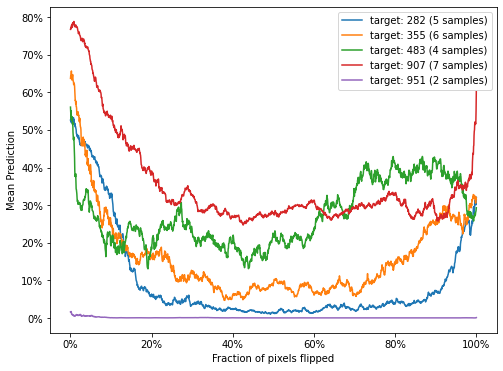

In [ ]:
# Return pixel-flipping scores in an one-liner - by calling the metric instance.
scores = quantus.PixelFlipping(**{
    "features_in_step": 28,
    "perturb_baseline": "black",
    "perturb_func": quantus.baseline_replacement_ (_indices,
})(model=model,
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

# Plot example!
quantus.plot_pixel_flipping_experiment(y_batch=y_batch, scores=scores)

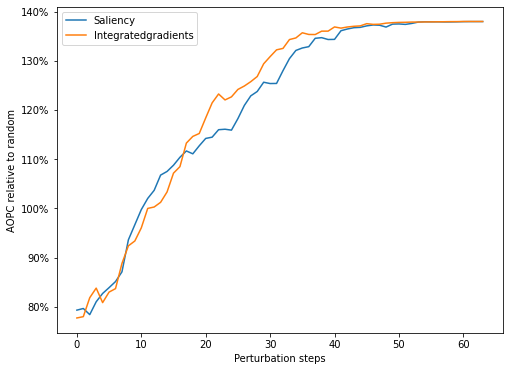

In [ ]:
# Return region perturbation scores in an one-liner - by calling the metric instance.
results = {method: quantus.RegionPerturbation(**{
    "patch_size": 28,
    "regions_evaluation": 100,
    "img_size": 224,
    "random_order": False,
    "perturb_func": quantus.baseline_replacement_ (_patch,
    "perturb_baseline": "uniform",  
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": method, "device": device}) for method in ["Saliency", "IntegratedGradients"]}

# Plot example!
quantus.plot_region_perturbation_experiment(results=results)

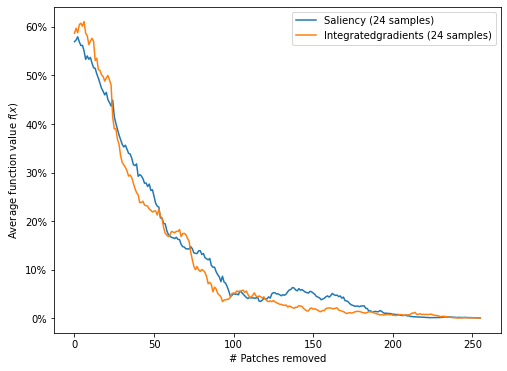

In [ ]:
# Return selectivity scores in an one-liner - by calling the metric instance.
results = {method: quantus.Selectivity(**{
    "patch_size": 14,
    "perturb_func": quantus.baseline_replacement_ (_patch,
    "perturb_baseline": "black",  
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": method, "device": device}) for method in ["Saliency", "IntegratedGradients"]}

# Plot example!
quantus.plot_selectivity_experiment(results=results)

No handles with labels found to put in legend.


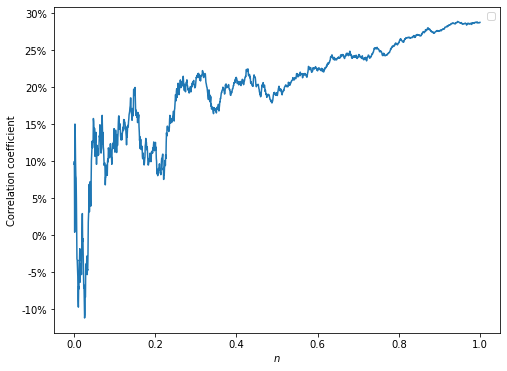

In [ ]:
# Return sensitivity-n scores in an one-liner - by calling the metric instance.
scores = quantus.SensitivityN(**{
    "features_in_step": 28,
    "n_max_percentage": 0.8,
    "img_size": 224,
    "similarity_func": quantus.correlation_pearson,
    "perturb_func": quantus.baseline_replacement_ (_indices,
    "perturb_baseline": "uniform",  
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

# Plot example!
quantus.plot_sensitivity_n_experiment(results=scores)

# TODO. Validate the curves - are they looking as expected?

In [ ]:
# Return IFOF scores in an one-liner - by calling the metric instance.
results = {method: quantus.IROF(**{
    "segmentation_method": "slic",
    "perturb_baseline": "mean",
    "perturb_func": quantus.baseline_replacement_ (_indices,
})(model=model,
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": method, "device": device}) for method in ["Gradient", "Saliency", "IntegratedGradients", "GradientShap"]}

results

{'Gradient': [68.20079040993858],
 'GradientShap': [68.22271214744474],
 'IntegratedGradients': [68.2321012141051],
 'Saliency': [68.20052606718771]}

In [ ]:
# TODO. Bug fixes.
'''
# Return infidelity scores in an one-liner - by calling the metric instance.
quantus.Infidelity(**{
    "loss_func": quantus.mse,
    "img_size": 224,
    "perturb_patch_sizes": [8, 14, 28],
    "perturb_baseline": "black",  
    "perturb_func": quantus.baseline_replacement_ (_patch,
})(model=model, 
   x_batch=x_batch, 
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})
''';

#### Robustness metrics 

Score explanations using the following robustness metrics:

* Local Lipschitz Estimate (Alvarez-Melis et al., 2018; 2019)
* Max-Sensitivity (Yeh at el., 2019)
* Avg-Sensitivity (Yeh at el., 2019)
* Continuity (Montavan et al., 2017)
* Input Independence Rate (Yang et al., 2019)

In [ ]:
# Return local lipschitzEstimate estimate scores in an one-liner - by calling the metric instance.
quantus.LocalLipschitzEstimate(**{
    "nr_samples": 10,
    "perturb_std": 0.1,
    "norm_numerator": quantus.distance_euclidean,
    "norm_denominator": quantus.distance_euclidean,
    "explain_func": quantus.explain,
    "perturb_func": quantus.gaussian_noise,
    "similarity_func": quantus.lipschitz_constant,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"method": "Saliency", "device": device})

[64.44513075533496,
 102.84754647596942,
 74.3879775461638,
 82.0244600175701,
 62.75986799274318,
 78.45416845248923,
 66.2233842823959,
 132.6886994298651,
 53.42708769353093,
 73.12900921144158,
 97.64568256647112,
 79.94009263718405,
 56.67007823242151,
 86.52394317438694,
 72.42729352899593,
 55.37171436739245,
 55.48998401395281,
 61.4079068146684,
 104.19230045948137,
 93.1243168486063,
 65.5218090710722,
 88.2721878193265,
 139.26501696995135,
 80.69803310165125]

In [ ]:
# Return max sensitivity scores in an one-liner - by calling the metric instance.
quantus.MaxSensitivity(**{
    "nr_samples": 10,
    "perturb_radius": 0.2,
    "norm_numerator": quantus.fro_norm,
    "norm_denominator": quantus.fro_norm,
    "explain_func": quantus.explain,
    "perturb_func": quantus.uniform_sampling,
    "similarity_func": quantus.difference,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"method": "Saliency", "device": device})

[0.017128654,
 0.034615,
 0.02866665,
 0.011896606,
 0.03307318,
 0.06139419,
 0.051570114,
 0.028542856,
 0.027542109,
 0.018767621,
 0.014477151,
 0.030449748,
 0.03863772,
 0.069662556,
 0.03108715,
 0.017437855,
 0.048724156,
 0.021958254,
 0.037339058,
 0.017925242,
 0.02814223,
 0.02422402,
 0.05357002,
 0.05848489]

In [ ]:
# Return avg sensitivity scores in an one-liner - by calling the metric instance.
quantus.AvgSensitivity(**{
    "nr_samples": 10,
    "perturb_radius": 0.2,
    "norm_numerator": quantus.fro_norm,
    "norm_denominator": quantus.fro_norm,
    "explain_func": quantus.explain,
    "perturb_func": quantus.uniform_sampling,
    "similarity_func": quantus.difference,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"method": "Saliency", "device": device})

[0.017828868702054024,
 0.05963929742574692,
 0.04421377182006836,
 0.016141977161169052,
 0.021119093522429466,
 0.05297933891415596,
 0.04147179424762726,
 0.06225193664431572,
 0.01863543689250946,
 0.029246002435684204,
 0.024779191240668297,
 0.01804058812558651,
 0.026470307260751724,
 0.03374655172228813,
 0.02835090085864067,
 0.01039061602205038,
 0.045434582978487015,
 0.02882593497633934,
 0.04047077149152756,
 0.05121723935008049,
 0.039143070578575134,
 0.04299604147672653,
 0.060314834117889404,
 0.02958831749856472]

In [ ]:
# Return continuity scores in an one-liner - by calling the metric instance.
quantus.Continuity(**{
    "nr_patches": 4,
    "nr_steps": 10,
    "img_size": 224,
    "perturb_baseline": "black",
    "explain_func": quantus.explain,
    "similarity_func": quantus.correlation_spearman,
    "perturb_func": quantus.translation_x_direction,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"method": "IntegratedGradients", "device": device})

#print(f"Continutity correlation score: {continuity_test.continutity_correlation_score:.4f}")

{0: {0: [474.469846961671,
   513.4295729582886,
   320.8664545444386,
   262.66360271852005,
   97.81997028984809,
   63.81411016623309,
   62.96026421684343,
   47.778211956463366,
   39.58043639149781,
   87.65896232745746],
  1: [579.126190288187,
   779.989148761237,
   620.1249434418407,
   748.5960998269265,
   587.7920289679073,
   561.3524969143416,
   551.7342053488597,
   443.81784208951643,
   216.78555406703754,
   304.23373781007876],
  2: [544.7673425490434,
   690.3749663039048,
   413.7953271810791,
   269.88916244776595,
   118.92238804023319,
   63.13231933796476,
   57.1091216754714,
   37.21811625860501,
   26.91962112679998,
   56.12356868028587],
  3: [325.6955283439911,
   471.529799392702,
   349.99458119202956,
   486.58567953114175,
   581.6541564619539,
   558.8174624876215,
   617.1122758325978,
   450.0653637389306,
   185.42875038153528,
   249.00126155697603],
  4: [9.44107723236084,
   8.484042167663574,
   8.640423774719238,
   7.601589202880859,
   8.

In [ ]:
# TODO. Remove from library - iteration 1.
'''
# Return input independence rate scores in an one-liner - by calling the metric instance.
quantus.InputIndependenceRate(**{
    "similarity_func": abs_difference,
    "perturb_func": optimization_scheme, # TODO.
    "perturb_std": 0.01,
    "threshold": 0.025, # 0.1
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=a_batch,
   **{"explanation_func": explain, "method": method, "device": device})
''';

### Randomization metrics

In [ ]:
# Return model parameter randomization scores in an one-liner - by calling the metric instance.
quantus.ModelParameterRandomization(**{
    "layer_order": "independent",
    "similarity_func": quantus.correlation_spearman,
    "explain_func": quantus.explain, 
    "normalize": True,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"method": "IntegratedGradients", "device": device})

[{'bn1': 0.006574638836486189,
  'conv1': 0.002081433897661955,
  'fc': -0.005450160310370663,
  'layer1.0.bn1': 0.006882693985193837,
  'layer1.0.bn2': 0.0010338385627629001,
  'layer1.0.conv1': 0.008856319856760372,
  'layer1.0.conv2': 0.0008548606075055965,
  'layer1.1.bn1': 0.0012966116405161274,
  'layer1.1.bn2': -0.0002698148547565931,
  'layer1.1.conv1': -0.0040013804138258145,
  'layer1.1.conv2': 0.0009748874201330932,
  'layer2.0.bn1': 0.004417007829324075,
  'layer2.0.bn2': -0.011236916556352335,
  'layer2.0.conv1': -0.0029717832397422967,
  'layer2.0.conv2': 0.0006490629208210967,
  'layer2.0.downsample.0': -0.003386459151173588,
  'layer2.0.downsample.1': -0.0016538066996794418,
  'layer2.1.bn1': -0.001995526889463239,
  'layer2.1.bn2': -0.0006466147596620013,
  'layer2.1.conv1': -0.004494056100103289,
  'layer2.1.conv2': -0.001651809314526096,
  'layer3.0.bn1': -0.004366872184858072,
  'layer3.0.bn2': 0.006913754560988379,
  'layer3.0.conv1': -0.0037298421951582374,
  'lay

In [ ]:
# Return random logit scores in an one-liner - by calling the metric instance.
quantus.RandomLogit(**{
    "max_class": 10,
    "similarity_func": quantus.ssim,
    "explain_func": quantus.explain, 
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"method": "IntegratedGradients", "device": device})

### Complexity metrics

Score explanations using the following complexity metrics:

* Sparseness (Alvarez-Melis et al., 2018; 2019)
* Complexity (Yeh at el., 2019)
* Effective complexity (Yeh at el., 2019)

In [ ]:
# Return sparseness scores in an one-liner - by calling the metric instance.
quantus.Sparseness(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

[0.5835364274817236,
 0.6019830430515627,
 0.6537423009586569,
 0.5818013194006535,
 0.6530071765617174,
 0.606819106976281,
 0.6621538926230108,
 0.5805141346342729,
 0.6268035427733635,
 0.6735505833741371,
 0.5574163644251714,
 0.5178362446914135,
 0.6380838943496342,
 0.5869310640811195,
 0.5871857828953065,
 0.59657438033717,
 0.6858215129970409,
 0.6096001984500017,
 0.5480378865351442,
 0.609106907368969,
 0.654918332764918,
 0.6333321797345302,
 0.5597462847920982,
 0.5412317380634489]

In [ ]:
# Return complexity scores in an one-liner - by calling the metric instance.
quantus.Complexity(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

[10.193702108466148,
 10.168639986052668,
 10.002272416818151,
 10.214646332324493,
 9.987395318320775,
 10.146140406050336,
 9.97634885716754,
 10.222894203719257,
 10.114265472368865,
 9.919515153495881,
 10.276742851350445,
 10.359319276051078,
 10.041639868806593,
 10.203925187871384,
 10.211065296386044,
 10.156989946751882,
 9.902359684778062,
 10.143801697842312,
 10.297196720372284,
 10.154976612278128,
 10.012964194805587,
 10.022469103402226,
 10.278771282650467,
 10.310889569839974]

In [ ]:
# Return effective complexity scores in an one-liner - by calling the metric instance.
quantus.EffectiveComplexity(**{
    "eps": 1e-5,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

### Axiomatic metrics

Score explanations using the following axiomatic metrics:

* Completeness (Montavon et al., 2018) - Additivity
* Non-sensitivity (Nguyen at el., 2020) - Dummy
* Symmetry
* Input invaraince

In [ ]:
# Return completeness scores in an one-liner - by calling the metric instance.
quantus.Completeness(**{
    "abs": False,
    #"output_func": torch.nn.Softmax(),
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [ ]:
# Return non-sensitivity scores in an one-liner - by calling the metric instance.
quantus.NonSensitivity(**{
    "abs": True,
    "eps": 1e-5,
    "perturb_baseline": "black",
    "perturb_func": quantus.baseline_replacement_by_indices,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

### Localisation metrics

* Pointing Game (Zhang et al., 2018)
* Attribution Localization (Kohlbrenner et al., 2020)
* TKI (Theiner et al., 2021)
* Relevance Rank Accuracy (Arras et al., 2021)
* Relevance Mass Accuracy (Arras et al., 2021)

In [ ]:
# For the localisation metrics we need to load a dataset that has ground truth masks.

# TODO. Insert here.

In [ ]:
# Return effective complexity scores in an one-liner - by calling the metric instance.
quantus.PointingGame(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

In [ ]:
# Return attribution localization scores in an one-liner - by calling the metric instance.
quantus.AttributionLocalization(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

In [ ]:
# Return tki scores in an one-liner - by calling the metric instance.
quantus.TopKIntersection(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

In [ ]:
# Return relevane rank accuracy scores in an one-liner - by calling the metric instance.
quantus.RelevanceRankAccuracy(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

In [ ]:
# Return relevane mass accuracy scores in an one-liner - by calling the metric instance.
quantus.RelevanceMassAccuracy(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})